### DWD AI TS (Thunderstorm)

This notebook loads and visualises the DWD AI TS (Thunderstorm) product over Africa.  
The TS field is a dimensionless (0–1) machine-learning–based thunderstorm severity index, provided at 15-minute temporal resolution with multiple time steps per file on a regular lat–lon grid.

In [75]:
import bz2
import tempfile
import os

import numpy as np 
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

import cartopy.crs as ccrs                              
import cartopy.feature as cfeature                   
import cartopy.io.shapereader as shpreader

import warnings
warnings.filterwarnings("ignore")

In [76]:
def get_ts_file(path_TS, t0):
    
    # bias file selection backwards by one cycle
    t_file = t0 - timedelta(minutes=15)
    date_str = t_file.strftime("%Y%m%d")

    guess = (
        f"{path_TS}/{date_str}/"
        f"TSfc{t_file:%Y%m%d%H%M}EA.nc.bz2"
    )

    if os.path.exists(guess):
        return guess

    # fallback: find closest file by filename time (still relative to t0)
    ts_dir = f"{path_TS}/{date_str}"
    files = [f for f in os.listdir(ts_dir) if f.startswith("TSfc")]

    times = [
        datetime.strptime(f[4:16], "%Y%m%d%H%M")
        for f in files
    ]

    i = min(range(len(times)), key=lambda i: abs(times[i] - t0))
    return os.path.join(ts_dir, files[i])

In [77]:
def load_ts_at_time_bz2(ts_file, t0):
    
    with bz2.open(ts_file, "rb") as f:
        ds = Dataset("inmemory.nc", memory=f.read())

    ts = ds.variables["TS"][:]          # (time, lat, lon)
    time_var = ds.variables["time"]
    times = num2date(time_var[:], units=time_var.units)

    # prefer latest TS time <= t0
    idx = np.where(times <= t0)[0]

    if len(idx) > 0:
        i = idx[-1]
    else:
        # fallback: closest time
        i = np.argmin([abs(t - t0) for t in times])

    ts_t0 = ts[i]
    time_used = times[i]

    lat = ds.variables["lat"][:]
    lon = ds.variables["lon"][:]

    ds.close()

    return ts_t0, time_used, lat, lon


In [ ]:
from datetime import datetime

t0 = datetime(2024, 4, 24, 10, 20)

path_TS = "/gws/ssde/j25b/swift/WISER-EWSA/DWD_AI_TS/data"

ts_file = get_ts_file(path_TS, t0)

print(ts_file)

/gws/ssde/j25b/swift/WISER-EWSA/DWD_AI_TS/data/20240424/TSfc202404241015EA.nc.bz2


In [79]:
ts_field, ts_time, lat, lon = load_ts_at_time_bz2(ts_file, t0)

print("Requested time:", t0)
print("Actual TS time:", ts_time)

Requested time: 2024-04-24 10:20:00
Actual TS time: 2024-04-24 10:20:00


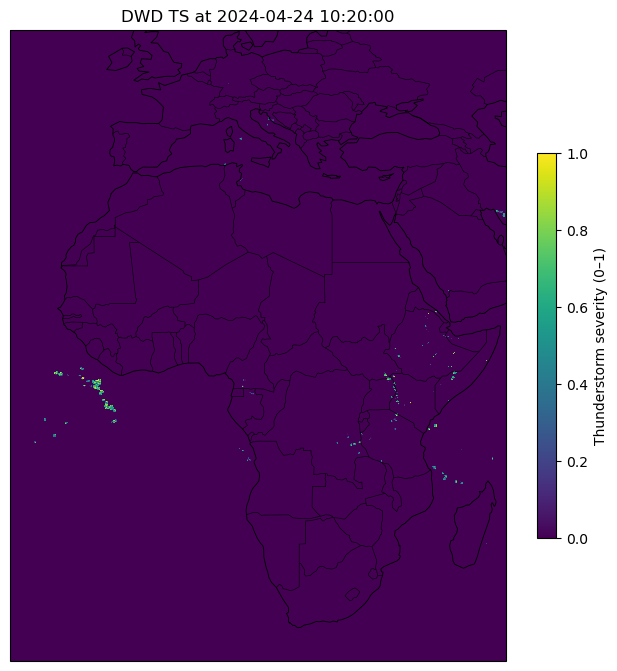

In [80]:
lon2d, lat2d = np.meshgrid(lon, lat)

ts_field = np.where(ts_field < 0, np.nan, ts_field)

plt.figure(figsize=(8, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(
    [lon.min(), lon.max(), lat.min(), lat.max()],
    crs=ccrs.PlateCarree()
)

ax.coastlines(resolution="110m", linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)


im = ax.pcolormesh(
    lon2d, lat2d, ts_field,
    cmap="viridis",
    vmin=0, vmax=1,
    transform=ccrs.PlateCarree()
)

plt.colorbar(im, label="Thunderstorm severity (0–1)", shrink=0.5, pad=0.05)
plt.title(f"DWD TS at {ts_time}")
plt.show()
